In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## Exploración de datos

In [2]:
jm_train = pd.read_csv("jm_train.csv")

In [3]:
jm_train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


In [4]:
jm_train.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


In [5]:
jm_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


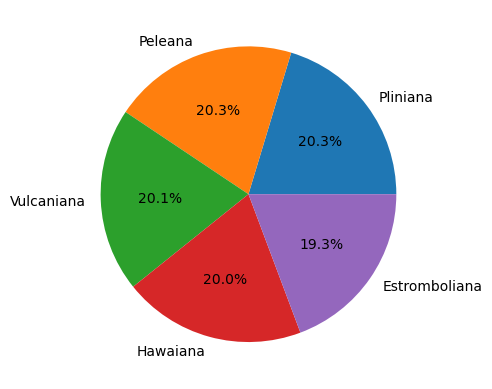

In [6]:
pie_chart = jm_train["target"].value_counts(normalize=True) * 100

plt.pie(pie_chart,autopct="%1.1f%%", labels = ["Pliniana","Peleana","Vulcaniana","Hawaiana","Estromboliana"])
plt.show()

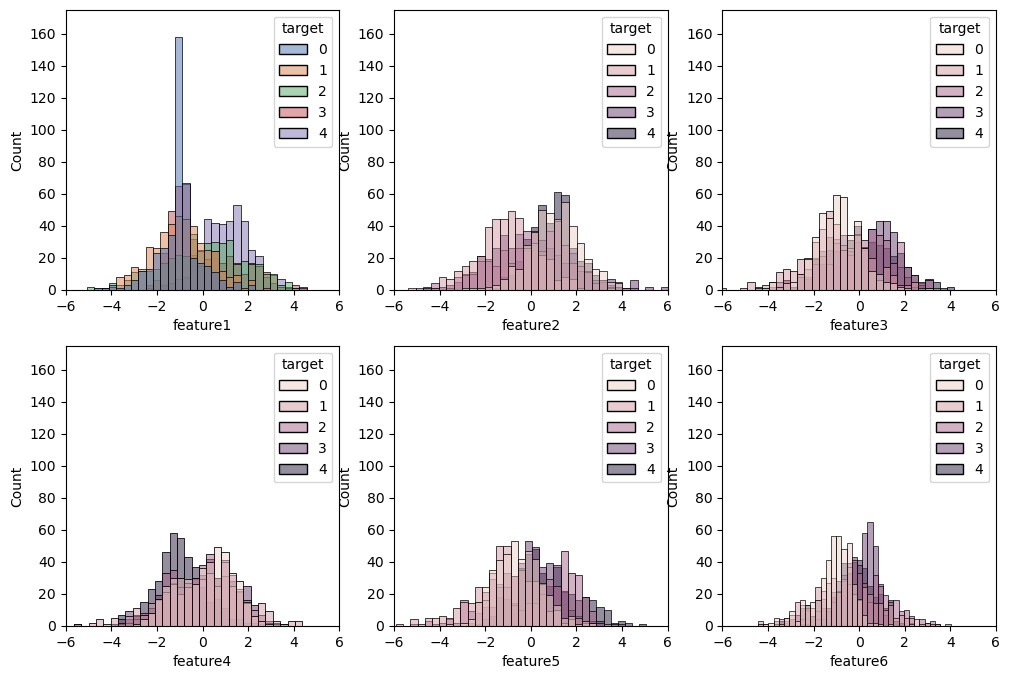

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(12,8))

sns.histplot(jm_train, x="feature1", hue="target", palette="deep",ax=axs[0, 0])
sns.histplot(jm_train, x="feature2", hue="target", ax=axs[0, 1])
sns.histplot(jm_train, x="feature3", hue="target", ax=axs[0, 2])

sns.histplot(jm_train, x="feature4", hue="target", ax=axs[1, 0])
sns.histplot(jm_train, x="feature5", hue="target", ax=axs[1, 1])
sns.histplot(jm_train, x="feature6", hue="target", ax=axs[1, 2])

axs[0,0].set_xlim(-6,6)
axs[0,1].set_xlim(-6,6)
axs[0,2].set_xlim(-6,6)
axs[1,0].set_xlim(-6,6)
axs[1,1].set_xlim(-6,6)
axs[1,2].set_xlim(-6,6)

axs[0,0].set_ylim(0,175)
axs[0,1].set_ylim(0,175)
axs[0,2].set_ylim(0,175)
axs[1,0].set_ylim(0,175)
axs[1,1].set_ylim(0,175)
axs[1,2].set_ylim(0,175)


plt.show()

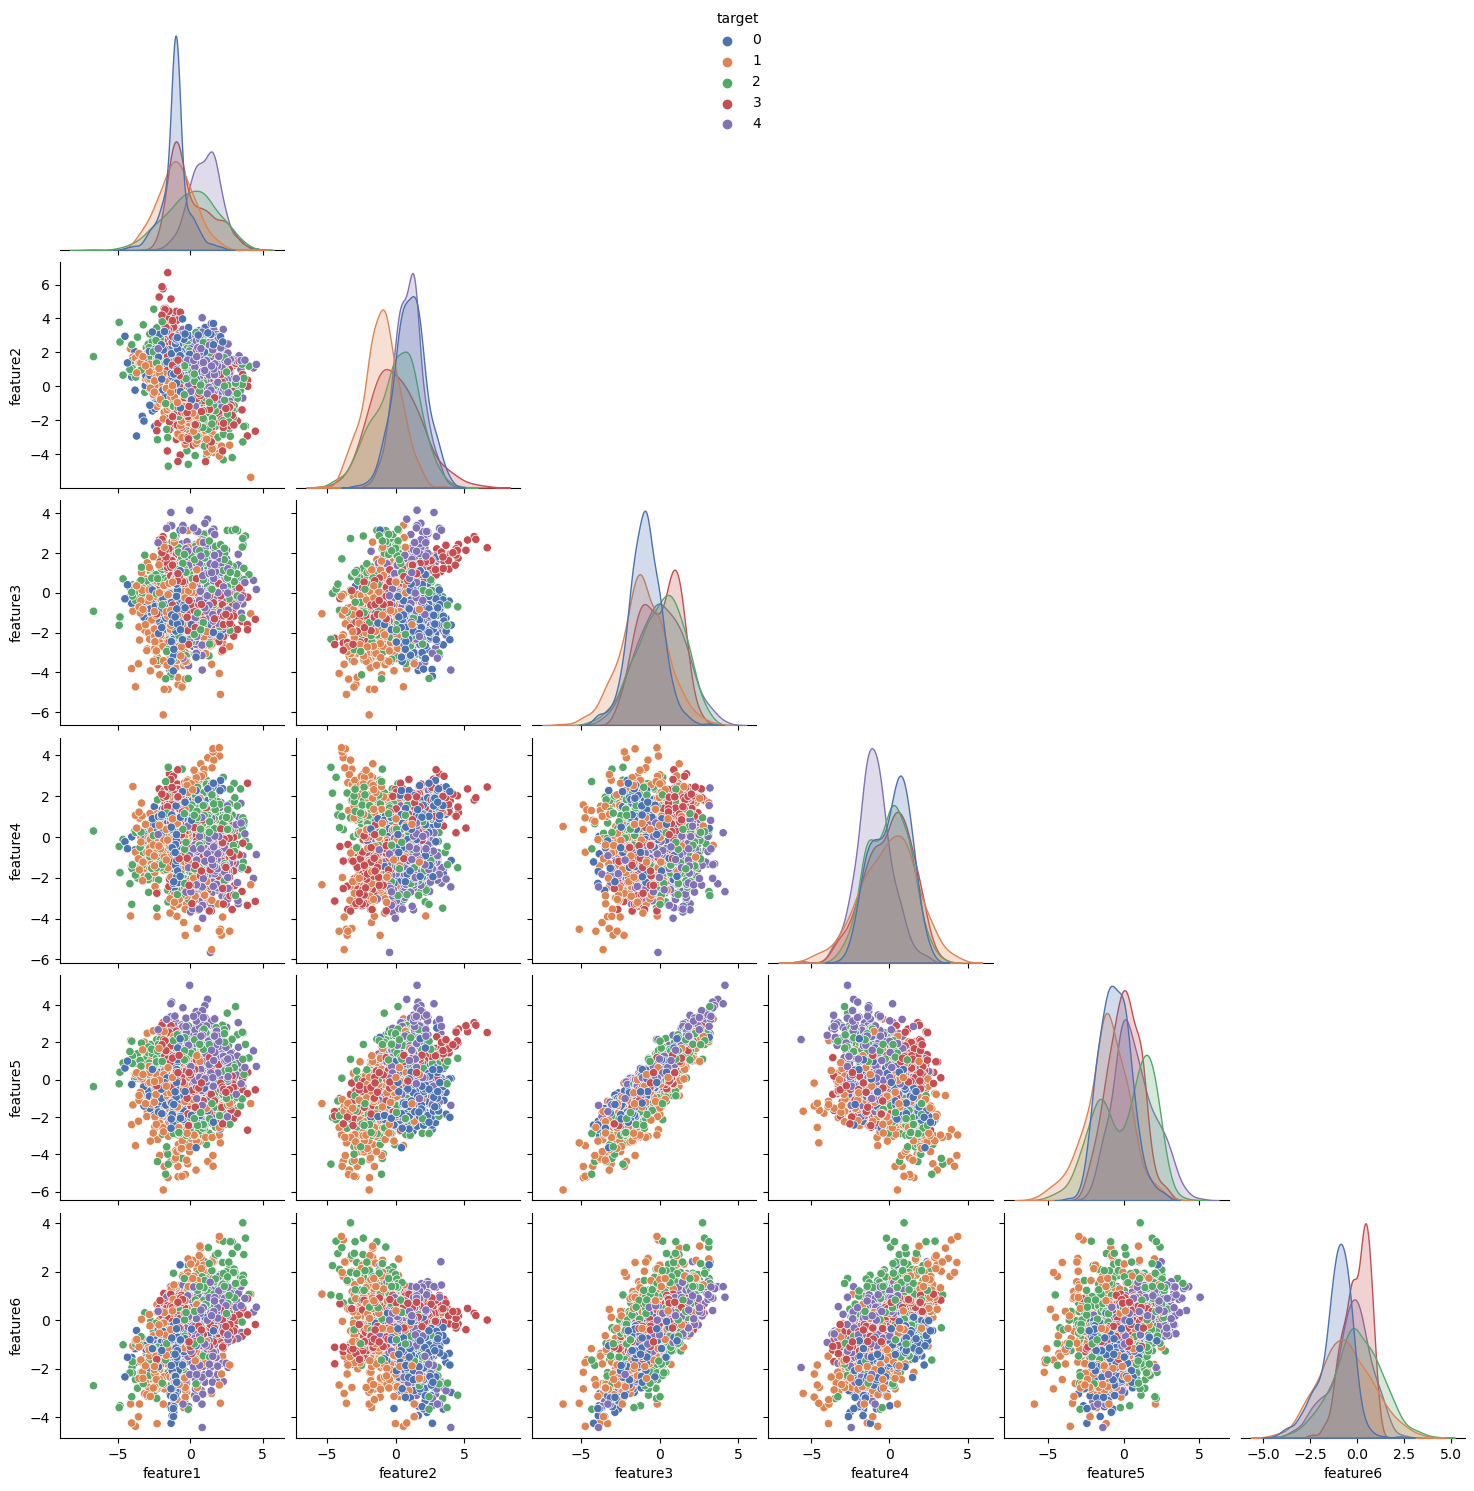

In [8]:
g=sns.pairplot(jm_train, hue="target",corner= True ,palette = "deep")

sns.move_legend(g, loc="upper center")
plt.show()

## Modelo predictivo

In [9]:
x_train = jm_train[["feature1","feature2","feature3","feature4","feature5","feature6"]]
y_train = jm_train[["target"]]

In [10]:
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier(random_state=7))])

score = cross_val_score( pipe, x_train, y_train.values.ravel(), cv = 5,scoring = "f1_macro")
score_mean = score.mean()
score_var = np.var(score)

print("Media f1_macro: "+str(score_mean))
print("Varianza f1_macro: " + str(score_var))

Media f1_macro: 0.7682874945132088
Varianza f1_macro: 0.00010922253511090809


In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt',"log2",None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'RFC__n_estimators': n_estimators,
               'RFC__max_features': max_features,
               'RFC__max_depth': max_depth,
               'RFC__min_samples_split': min_samples_split,
               'RFC__min_samples_leaf': min_samples_leaf,
               'RFC__bootstrap': bootstrap}


search = RandomizedSearchCV(pipe, param_distributions=random_grid,scoring = "f1_macro",n_jobs=-1)

search.fit(x_train, y_train.values.ravel())
search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('RFC',
                 RandomForestClassifier(bootstrap=False, max_depth=60,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=7))])

In [19]:
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier(bootstrap=False, max_depth=60, min_samples_split=10,
                       n_estimators=200, random_state=7))])

score = cross_val_score( pipe, x_train, y_train.values.ravel(), cv = 5,scoring = "f1_macro")
score_mean = score.mean()
score_var = np.var(score)

print("Media f1_macro: "+str(score_mean))
print("Varianza f1_macro: " + str(score_var))

Media f1_macro: 0.7712888475673729
Varianza f1_macro: 0.00038141720204687435


In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 8)]
# Maximum number of levels in tree
max_depth = [40,50,60,70,80]
# Minimum number of samples required to split a node
min_samples_split = [ 8, 10,12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5]
# Create the random grid
param_grid = {'RFC__n_estimators': n_estimators,               
               'RFC__max_depth': max_depth,
               'RFC__min_samples_split': min_samples_split,
               'RFC__min_samples_leaf': min_samples_leaf}


search = RandomizedSearchCV(pipe, param_distributions=param_grid,scoring = "f1_macro",n_jobs=-1)

search.fit(x_train, y_train.values.ravel())
search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('RFC',
                 RandomForestClassifier(bootstrap=False, max_depth=40,
                                        min_samples_split=10, n_estimators=150,
                                        random_state=7))])

In [21]:
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_split=10,
                       n_estimators=150, random_state=7))])

score = cross_val_score( pipe, x_train, y_train.values.ravel(), cv = 5,scoring = "f1_macro")
score_mean = score.mean()
score_var = np.var(score)

print("Media f1_macro: "+str(score_mean))
print("Varianza f1_macro: " + str(score_var))

Media f1_macro: 0.77220598932806
Varianza f1_macro: 0.00037609010671021324
